# Network Intrusion Detection with Machine Learning  
## CICIDS2017 + Cross-Dataset Validation on UNSW-NB15

### Project Goal
Build an intrusion detection ML pipeline to classify **Normal vs Attack** traffic.  
We use **CICIDS2017** as the main dataset (EDA + supervised models + evaluation), and compare insights and modeling behavior with **UNSW-NB15** to examine whether conclusions generalize across datasets.

### Key Contributions
- Data quality analysis (NaN/Inf/duplicates, class imbalance, outliers)
- Leakage-aware train/test split for CICIDS2017 using **group split by source file**
- Supervised baselines + stronger models, evaluated with **PR-AUC** and attack-oriented metrics
- Cross-dataset comparison: data quality + feature importance families + performance patterns


In [ ]:
# =========================
# 1) Imports & Setup
# =========================
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_fscore_support, confusion_matrix
)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

RANDOM_STATE = 42


## 2) Data Loading
We assume the data is already available in Colab under:
- CICIDS2017: `/content/data/cicids/` containing multiple CSV files (days/sessions)
- UNSW-NB15: `/content/data/unsw/UNSW_NB15_training-set.csv` and `...testing-set.csv`

We load CICIDS2017 by concatenating all CSVs and keep a `source_file` column for **leakage-aware splitting**.
We keep UNSW training/test splits **separate** (do not concatenate) to respect the official evaluation setting.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# =========================
# 2) Paths
# =========================
CIC_DIR = "/content/data/cicids"
UNSW_DIR = "/content/data/unsw"

UNSW_TRAIN_PATH = os.path.join(UNSW_DIR, "UNSW_NB15_training-set.csv")
UNSW_TEST_PATH  = os.path.join(UNSW_DIR, "UNSW_NB15_testing-set.csv")

print("CIC_DIR:", CIC_DIR)
print("UNSW_TRAIN_PATH:", UNSW_TRAIN_PATH)
print("UNSW_TEST_PATH :", UNSW_TEST_PATH)


CIC_DIR: /content/data/cicids
UNSW_TRAIN_PATH: /content/data/unsw/UNSW_NB15_training-set.csv
UNSW_TEST_PATH : /content/data/unsw/UNSW_NB15_testing-set.csv


In [ ]:
import os, shutil

os.makedirs("/content/data/cicids", exist_ok=True)
os.makedirs("/content/data/unsw", exist_ok=True)

# copy CIC folder
src_cic = "/content/drive/MyDrive/datasets/archive"
dst_cic = "/content/data/cicids"
shutil.copytree(src_cic, dst_cic, dirs_exist_ok=True)

# copy UNSW folder
src_unsw = "/content/drive/MyDrive/datasets/archive-2"
dst_unsw = "/content/data/unsw"
shutil.copytree(src_unsw, dst_unsw, dirs_exist_ok=True)

print("Copied to /content/data")


✅ Copied to /content/data


In [ ]:
# =========================
# 2A) Load CICIDS2017
# =========================
cic_files = sorted(glob.glob(os.path.join(CIC_DIR, "*.csv")))
print("Found CIC files:", len(cic_files))
for f in cic_files[:5]:
    print(" -", os.path.basename(f))
if len(cic_files) > 5:
    print(" ...")

cic_parts = []
for f in cic_files:
    df = pd.read_csv(f)
    df["source_file"] = os.path.basename(f)
    cic_parts.append(df)

cic = pd.concat(cic_parts, ignore_index=True)
cic.columns = cic.columns.str.strip()  # important for CIC column names
print("CIC shape:", cic.shape)
cic.head(3)


Found CIC files: 8
 - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
 - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
 - Friday-WorkingHours-Morning.pcap_ISCX.csv
 - Monday-WorkingHours.pcap_ISCX.csv
 - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
 ...
CIC shape: (2830743, 80)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,source_file
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


In [ ]:
# =========================
# 2B) Load UNSW-NB15 (keep official split)
# =========================
unsw_train = pd.read_csv(UNSW_TRAIN_PATH)
unsw_test  = pd.read_csv(UNSW_TEST_PATH)

print("UNSW train shape:", unsw_train.shape)
print("UNSW test shape :", unsw_test.shape)
unsw_train.head(3)


UNSW train shape: (82332, 45)
UNSW test shape : (175341, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0


## 3) Label Definition
We unify both datasets into a binary target:
- `y = 0` → Normal / Benign
- `y = 1` → Attack / Malicious

### CICIDS2017
CIC typically uses `Label` column with `BENIGN` vs specific attack types.
We create `y = (Label != "BENIGN")`.

### UNSW-NB15
UNSW typically uses `label` column where:
- `0` = normal
- `1` = attack
We keep it as `y`.


In [ ]:
# =========================
# 3A) CIC: create y from Label
# =========================
if "Label" not in cic.columns:
    raise ValueError("CIC dataset must include a 'Label' column. Please check your CIC CSV files.")

cic["y"] = (cic["Label"].astype(str).str.upper().str.strip() != "BENIGN").astype(int)
print("CIC attack rate:", cic["y"].mean().round(4))
cic["Label"].value_counts().head(10)


CIC attack rate: 0.197


,count
Label,
BENIGN,2273097
DoS Hulk,231073
PortScan,158930
DDoS,128027
DoS GoldenEye,10293
FTP-Patator,7938
SSH-Patator,5897
DoS slowloris,5796
DoS Slowhttptest,5499


In [ ]:
# =========================
# 3B) UNSW: ensure label exists, rename to y later in pipeline
# =========================
if "label" not in unsw_train.columns:
    raise ValueError("UNSW train must include a 'label' column.")
if "label" not in unsw_test.columns:
    raise ValueError("UNSW test must include a 'label' column.")

print("UNSW train attack rate:", unsw_train["label"].mean().round(4))
print("UNSW test  attack rate:", unsw_test["label"].mean().round(4))


UNSW train attack rate: 0.5506
UNSW test  attack rate: 0.6806


## 4) Data Quality Report
We evaluate:
- Missing values
- Infinite values (CIC has Inf sometimes)
- Duplicates
- Class imbalance

Important: We **do not** drop all NaNs globally (can bias results).
Instead, we handle NaN/Inf inside a preprocessing pipeline fitted only on the training set.


In [ ]:
def data_quality_summary(df, y_col=None, name="dataset"):
    df2 = df.copy()

    # numeric columns
    num_cols = df2.select_dtypes(include=[np.number]).columns
    inf_count = np.isinf(df2[num_cols]).sum().sum() if len(num_cols) else 0
    nan_count = df2.isna().sum().sum()
    dup_count = df2.duplicated().sum()

    summary = {
        "dataset": name,
        "rows": df2.shape[0],
        "cols": df2.shape[1],
        "total_nan": int(nan_count),
        "total_inf_num": int(inf_count),
        "duplicate_rows": int(dup_count),
    }
    if y_col and y_col in df2.columns:
        summary["attack_rate"] = float(df2[y_col].mean())
    return pd.DataFrame([summary])

dq_cic  = data_quality_summary(cic, y_col="y", name="CICIDS2017")
dq_unsw_train = data_quality_summary(unsw_train, y_col="label", name="UNSW-NB15 train")
dq_unsw_test  = data_quality_summary(unsw_test,  y_col="label", name="UNSW-NB15 test")
pd.concat([dq_cic, dq_unsw_train, dq_unsw_test], ignore_index=True)


,dataset,rows,cols,total_nan,total_inf_num,duplicate_rows,attack_rate
0,CICIDS2017,2830743,81,1358,4376,256479,0.196996
1,UNSW-NB15 train,82332,45,0,0,0,0.550600
2,UNSW-NB15 test,175341,45,0,0,0,0.680622


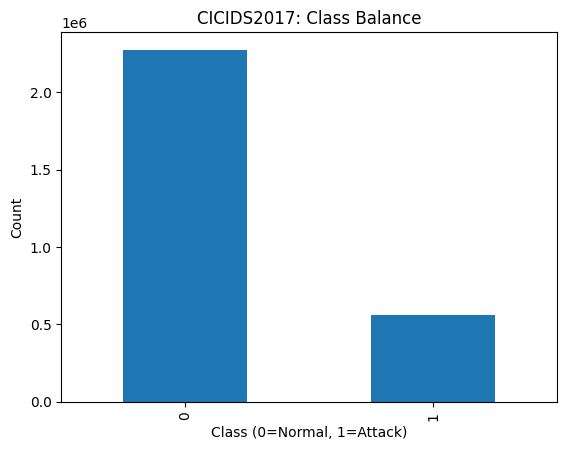

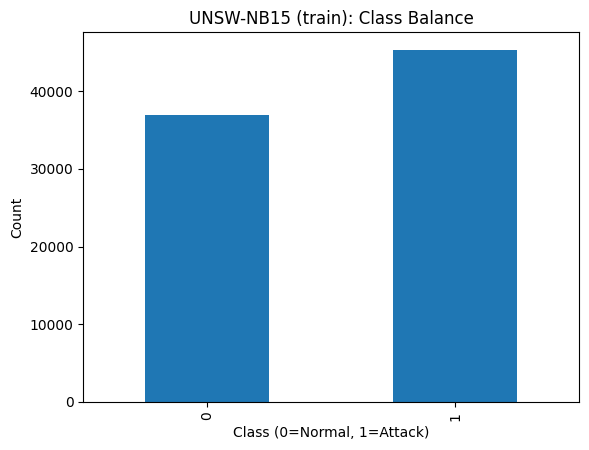

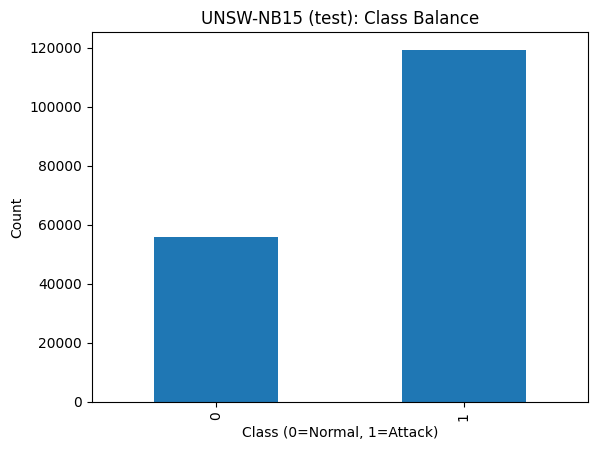

In [ ]:
# Class balance plot helper
def plot_class_balance(y, title="Class Balance"):
    counts = pd.Series(y).value_counts().sort_index()
    plt.figure()
    counts.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Class (0=Normal, 1=Attack)")
    plt.ylabel("Count")
    plt.show()

plot_class_balance(cic["y"], "CICIDS2017: Class Balance")
plot_class_balance(unsw_train["label"], "UNSW-NB15 (train): Class Balance")
plot_class_balance(unsw_test["label"], "UNSW-NB15 (test): Class Balance")


## 5) EDA (Focused)
We keep EDA concise and high-signal:
1) Distribution of selected numeric features (Normal vs Attack)
2) Correlation heatmap (top numeric features only)

Note: CIC and UNSW have different feature sets; we compare **patterns**, not identical columns.


CIC selected features: ['Flow Duration', 'Fwd IAT Total', 'Bwd IAT Total', 'Fwd IAT Max', 'Flow IAT Max', 'Idle Max']


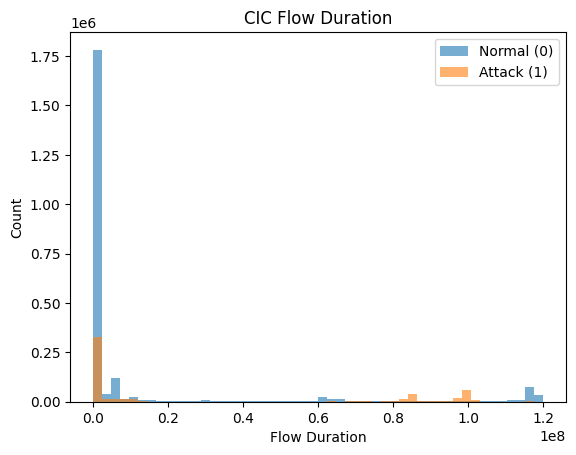

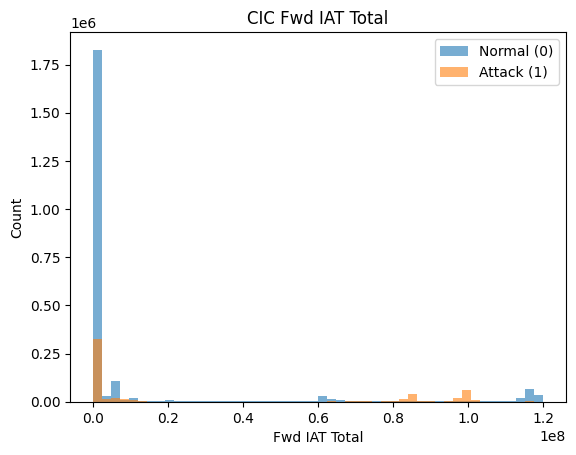

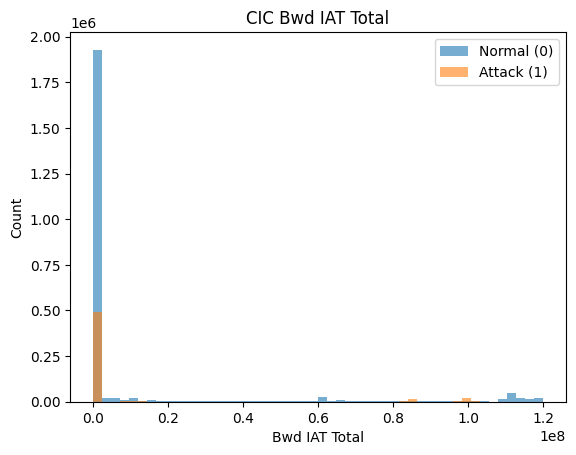

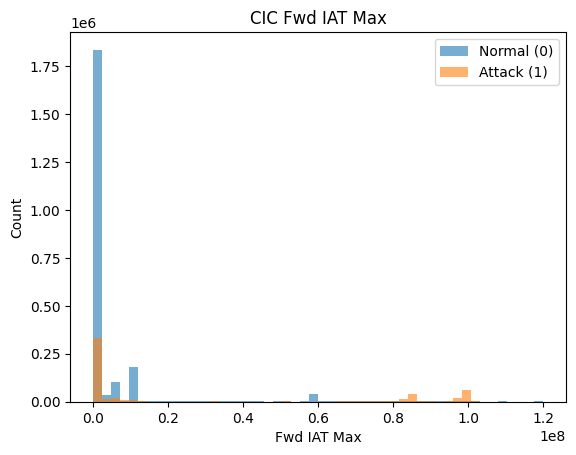

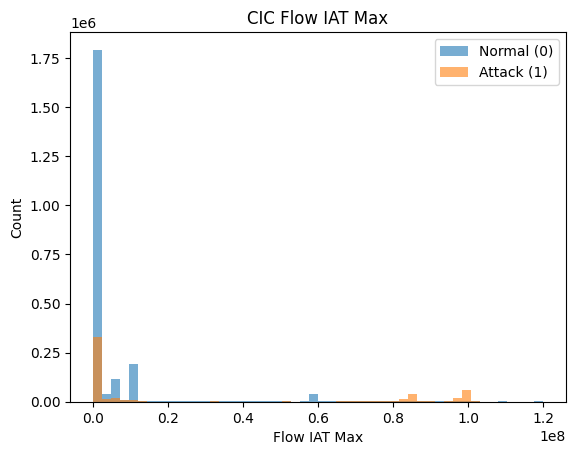

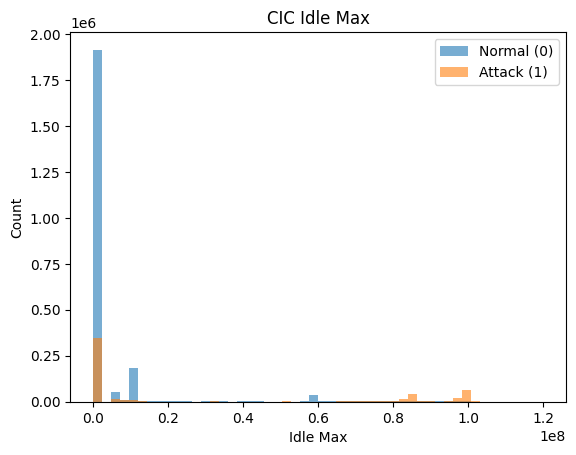

UNSW selected features: ['stcpb', 'dtcpb', 'sload', 'dload', 'sbytes', 'dbytes']


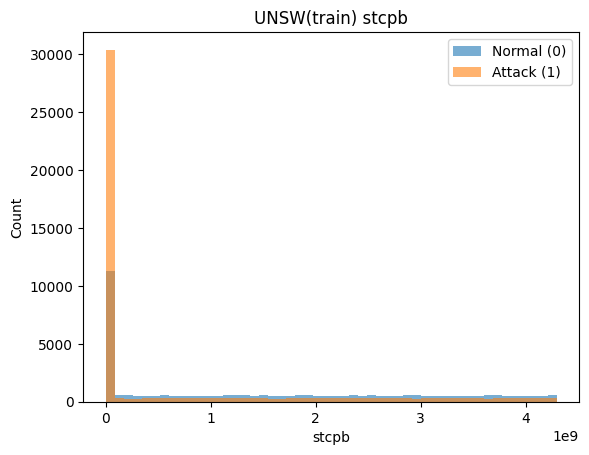

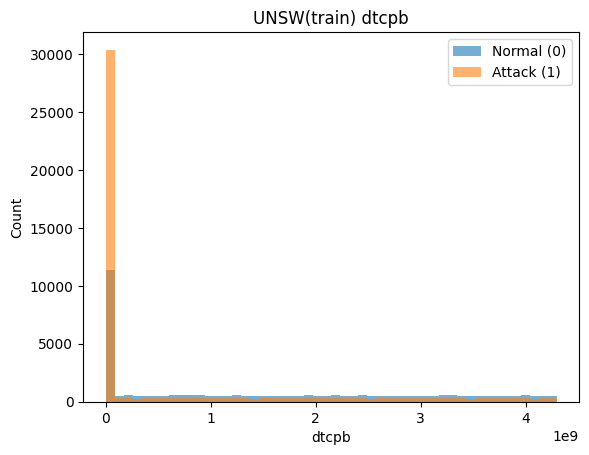

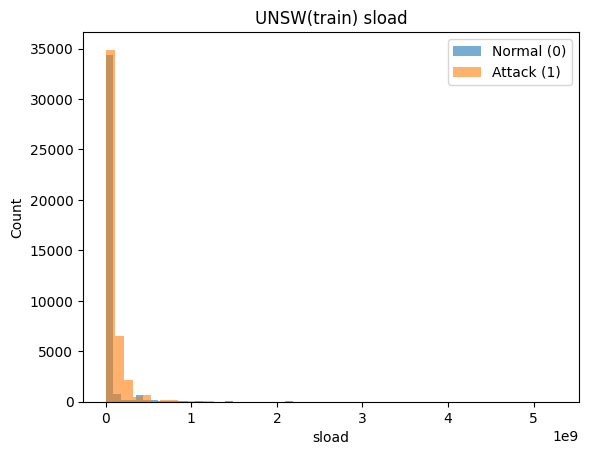

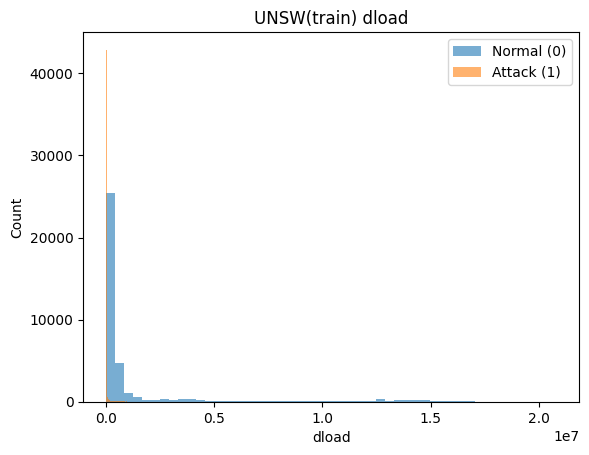

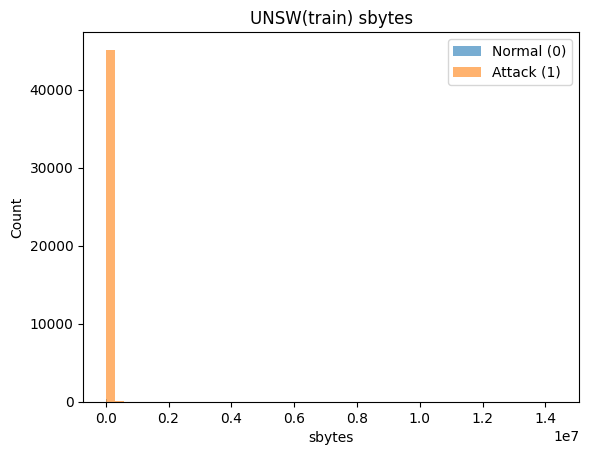

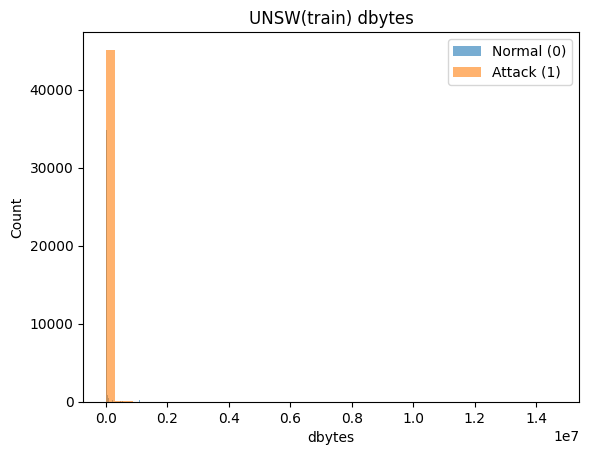

In [ ]:
def pick_numeric_features(df, exclude_cols=None, top_k=8):
    exclude_cols = set(exclude_cols or [])
    num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]
    # choose by variance as a simple heuristic
    if not num_cols:
        return []
    variances = df[num_cols].var(numeric_only=True).sort_values(ascending=False)
    return variances.head(top_k).index.tolist()

def plot_feature_distributions(df, y_col, features, title_prefix=""):
    # plots: hist overlays for each feature
    for f in features:
        plt.figure()
        df0 = df[df[y_col] == 0][f]
        df1 = df[df[y_col] == 1][f]
        plt.hist(df0.dropna(), bins=50, alpha=0.6, label="Normal (0)")
        plt.hist(df1.dropna(), bins=50, alpha=0.6, label="Attack (1)")
        plt.title(f"{title_prefix} {f}")
        plt.xlabel(f)
        plt.ylabel("Count")
        plt.legend()
        plt.show()

# CIC: pick high-variance numeric features (excluding y)
cic_feats = pick_numeric_features(cic, exclude_cols=["y"], top_k=6)
print("CIC selected features:", cic_feats)
plot_feature_distributions(cic, "y", cic_feats, title_prefix="CIC")

# UNSW train: pick features excluding label
unsw_feats = pick_numeric_features(unsw_train, exclude_cols=["label"], top_k=6)
print("UNSW selected features:", unsw_feats)
plot_feature_distributions(unsw_train, "label", unsw_feats, title_prefix="UNSW(train)")


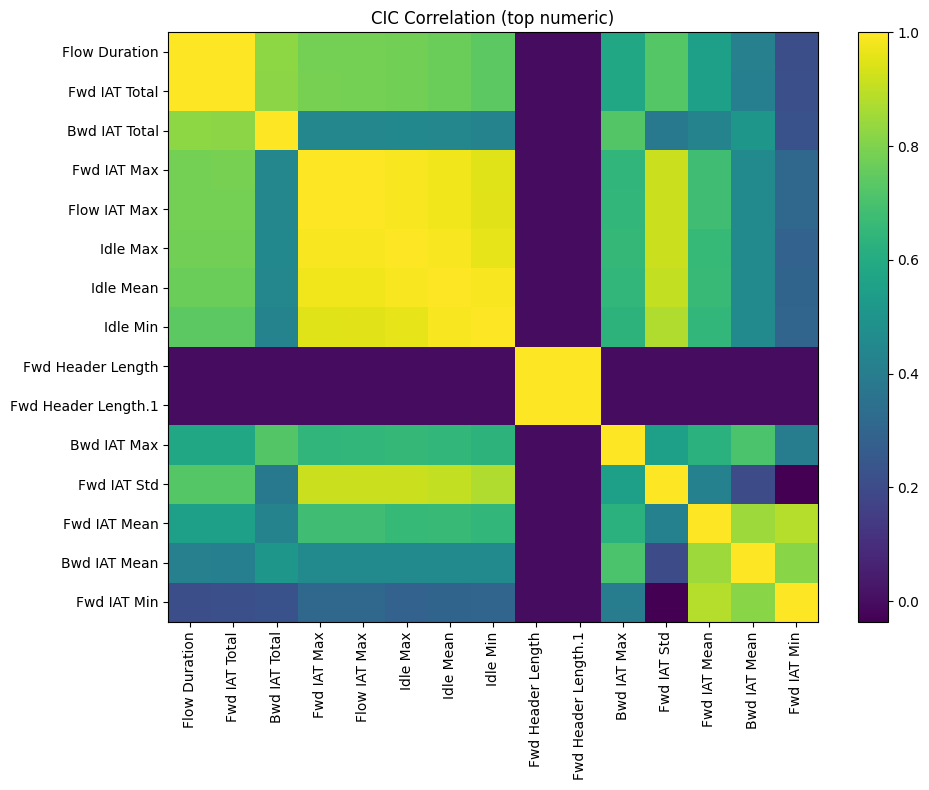

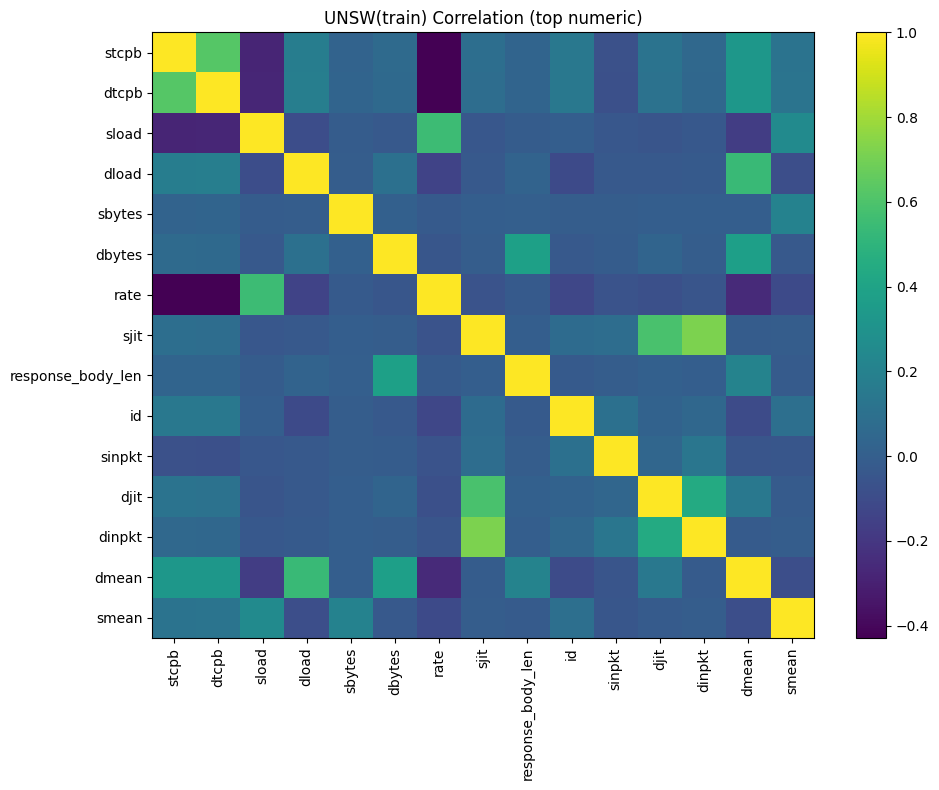

In [ ]:
def corr_heatmap(df, exclude_cols=None, top_k=15, title="Correlation (top variance numeric)"):
    exclude_cols = set(exclude_cols or [])
    num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]
    if len(num_cols) < 2:
        print("Not enough numeric columns for correlation.")
        return

    # pick top variance to keep plot readable
    variances = df[num_cols].var(numeric_only=True).sort_values(ascending=False)
    cols = variances.head(top_k).index.tolist()
    corr = df[cols].corr()

    plt.figure(figsize=(10, 8))
    plt.imshow(corr, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(cols)), cols, rotation=90)
    plt.yticks(range(len(cols)), cols)
    plt.title(title)
    plt.tight_layout()
    plt.show()

corr_heatmap(cic, exclude_cols=["y"], top_k=15, title="CIC Correlation (top numeric)")
corr_heatmap(unsw_train, exclude_cols=["label"], top_k=15, title="UNSW(train) Correlation (top numeric)")


## 6) Train/Test Splits (No Leakage)

### CICIDS2017
CIC is often composed of multiple files (days/sessions).  
To avoid leakage (learning dataset-specific patterns), we split by `source_file` using a **Group split**.

### UNSW-NB15
We keep the official train/test split provided by the dataset.


In [ ]:
# =========================
# 6A) CIC: Group split by source_file
# =========================
X_cic = cic.drop(columns=["y"], errors="ignore")
y_cic = cic["y"].astype(int)
groups = cic["source_file"].astype(str)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X_cic, y_cic, groups=groups))

Xc_train, Xc_test = X_cic.iloc[train_idx].copy(), X_cic.iloc[test_idx].copy()
yc_train, yc_test = y_cic.iloc[train_idx].copy(), y_cic.iloc[test_idx].copy()

print("CIC train:", Xc_train.shape, "attack rate:", yc_train.mean().round(4))
print("CIC test :", Xc_test.shape,  "attack rate:", yc_test.mean().round(4))
print("CIC unique source_file train:", Xc_train["source_file"].nunique(),
      "test:", Xc_test["source_file"].nunique())


CIC train: (2373910, 80) attack rate: 0.167
CIC test : (456833, 80) attack rate: 0.3527
CIC unique source_file train: 6 test: 2


In [ ]:
# =========================
# 6B) UNSW: Official split
# =========================
Xu_train = unsw_train.drop(columns=["label"], errors="ignore").copy()
yu_train = unsw_train["label"].astype(int).copy()

Xu_test  = unsw_test.drop(columns=["label"], errors="ignore").copy()
yu_test  = unsw_test["label"].astype(int).copy()

print("UNSW train:", Xu_train.shape, "attack rate:", yu_train.mean().round(4))
print("UNSW test :", Xu_test.shape,  "attack rate:", yu_test.mean().round(4))


UNSW train: (82332, 44) attack rate: 0.5506
UNSW test : (175341, 44) attack rate: 0.6806


## 7) Preprocessing Pipelines
We build preprocessing inside sklearn Pipelines to prevent leakage:
- Replace Inf → NaN (CIC numeric)
- Impute missing values (median for numeric, most_frequent for categorical)
- Standardize numeric for linear models
- One-hot encode categorical for UNSW


In [ ]:
# =========================
# 7A) CIC preprocessing
# =========================
# Remove target-leak columns from CIC modeling features: Label and source_file
def prepare_cic_X(df):
    df = df.copy()
    df = df.drop(columns=["Label", "source_file"], errors="ignore")

    # Replace inf with NaN for numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)
    return df

Xc_train_model = prepare_cic_X(Xc_train)
Xc_test_model  = prepare_cic_X(Xc_test)

cic_num_cols = Xc_train_model.select_dtypes(include=[np.number]).columns

cic_preprocess_lr = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), cic_num_cols)
    ],
    remainder="drop"
)

cic_preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
        ]), cic_num_cols)
    ],
    remainder="drop"
)

print("CIC numeric cols:", len(cic_num_cols))


CIC numeric cols: 78


In [ ]:
# =========================
# 7B) UNSW preprocessing (numeric + categorical)
# =========================
u_num_cols = Xu_train.select_dtypes(include=[np.number]).columns
u_cat_cols = Xu_train.select_dtypes(exclude=[np.number]).columns

unsw_preprocess_lr = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), u_num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), u_cat_cols),
    ],
    remainder="drop"
)

unsw_preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
        ]), u_num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), u_cat_cols),
    ],
    remainder="drop"
)

print("UNSW numeric cols:", len(u_num_cols), "| categorical cols:", len(u_cat_cols))


UNSW numeric cols: 40 | categorical cols: 4


## 8) Modeling & Evaluation
Because intrusion detection is usually **imbalanced**, accuracy is misleading.  
We focus on:
- **PR-AUC** (Average Precision) as the main ranking metric
- Attack-class Precision / Recall / F1
- Confusion matrix counts (TN/FP/FN/TP)

Models:
1) Dummy baseline (most frequent)
2) Logistic Regression with `class_weight="balanced"`
3) RandomForest with `class_weight="balanced_subsample"`


In [ ]:
def eval_binary(y_true, y_proba, threshold=0.5):
    y_true = np.asarray(y_true).astype(int)
    y_proba = np.asarray(y_proba)

    y_pred = (y_proba >= threshold).astype(int)
    pr_auc = average_precision_score(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred)
    return {
        "PR-AUC": pr_auc,
        "ROC-AUC": roc_auc,
        "Precision(attack)": prec,
        "Recall(attack)": rec,
        "F1(attack)": f1,
        "TN": cm[0,0], "FP": cm[0,1], "FN": cm[1,0], "TP": cm[1,1]
    }

def run_models(X_train, y_train, X_test, y_test, preprocess_lr, preprocess_tree, dataset_name=""):
    rows = []

    # Dummy
    dummy = Pipeline([
        ("prep", preprocess_tree),
        ("model", DummyClassifier(strategy="most_frequent"))
    ])
    dummy.fit(X_train, y_train)
    # Dummy may not have predict_proba in some strategies; here it does
    dummy_proba = dummy.predict_proba(X_test)[:, 1]
    rows.append({"Dataset": dataset_name, "Model": "Dummy(most_frequent)", **eval_binary(y_test, dummy_proba)})

    # Logistic Regression
    lr = Pipeline([
        ("prep", preprocess_lr),
        ("model", LogisticRegression(max_iter=3000, class_weight="balanced"))
    ])
    lr.fit(X_train, y_train)
    lr_proba = lr.predict_proba(X_test)[:, 1]
    rows.append({"Dataset": dataset_name, "Model": "LogReg(balanced)", **eval_binary(y_test, lr_proba)})

    # Random Forest
    rf = Pipeline([
        ("prep", preprocess_tree),
        ("model", RandomForestClassifier(
            n_estimators=300,
            random_state=RANDOM_STATE,
            class_weight="balanced_subsample",
            n_jobs=-1
        ))
    ])
    rf.fit(X_train, y_train)
    rf_proba = rf.predict_proba(X_test)[:, 1]
    rows.append({"Dataset": dataset_name, "Model": "RandomForest", **eval_binary(y_test, rf_proba)})

    return pd.DataFrame(rows)

# CIC results
df_cic = run_models(
    Xc_train_model, yc_train, Xc_test_model, yc_test,
    cic_preprocess_lr, cic_preprocess_tree,
    dataset_name="CICIDS2017"
)

# UNSW results
df_unsw = run_models(
    Xu_train, yu_train, Xu_test, yu_test,
    unsw_preprocess_lr, unsw_preprocess_tree,
    dataset_name="UNSW-NB15"
)

results_all = pd.concat([df_cic, df_unsw], ignore_index=True)
results_all = results_all.sort_values(["Dataset", "PR-AUC"], ascending=[True, False])
results_all


,Dataset,Model,PR-AUC,ROC-AUC,Precision(attack),Recall(attack),F1(attack),TN,FP,FN,TP
1,CICIDS2017,LogReg(balanced),0.557595,0.805465,0.009087,0.001186,0.002097,274896,20827,160919,191
2,CICIDS2017,RandomForest,0.548933,0.681141,0.256671,0.001254,0.002495,295138,585,160908,202
0,CICIDS2017,Dummy(most_frequent),0.352667,0.500000,0.000000,0.000000,0.000000,295723,0,161110,0
5,UNSW-NB15,RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,56000,0,0,119341
4,UNSW-NB15,LogReg(balanced),0.999927,0.999852,0.998967,0.996280,0.997621,55877,123,444,118897
3,UNSW-NB15,Dummy(most_frequent),0.680622,0.500000,0.680622,1.000000,0.809965,0,56000,0,119341


## 9) Threshold Tuning (Optional but Strong)
In IDS, we often prefer higher recall for attacks.
We evaluate a few thresholds and pick one that improves attack recall while keeping precision reasonable.
We demonstrate this on the best model (typically RandomForest or LogisticRegression).


In [ ]:
def threshold_sweep(model_pipeline, X_test, y_test, thresholds=(0.1, 0.2, 0.3, 0.5, 0.7)):
    proba = model_pipeline.predict_proba(X_test)[:, 1]
    rows = []
    for t in thresholds:
        metrics = eval_binary(y_test, proba, threshold=t)
        rows.append({"threshold": t, **metrics})
    return pd.DataFrame(rows).sort_values("threshold")

# Example: CIC RandomForest threshold sweep
cic_rf = Pipeline([
    ("prep", cic_preprocess_tree),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])
cic_rf.fit(Xc_train_model, yc_train)

cic_thr = threshold_sweep(cic_rf, Xc_test_model, yc_test)
cic_thr[["threshold", "PR-AUC", "Precision(attack)", "Recall(attack)", "F1(attack)", "FP", "FN", "TP"]]


,threshold,PR-AUC,Precision(attack),Recall(attack),F1(attack),FP,FN,TP
0,0.1,0.548933,0.719644,0.016076,0.031449,1009,158520,2590
1,0.2,0.548933,0.740339,0.014388,0.028227,813,158792,2318
2,0.3,0.548933,0.707087,0.010713,0.021107,715,159384,1726
3,0.5,0.548933,0.256671,0.001254,0.002495,585,160908,202
4,0.7,0.548933,0.275281,0.000912,0.001819,387,160963,147


## 10) Feature Importance
We compute top-15 feature importances using RandomForest.
Goal: Compare **feature families** (time/rate/bytes/packets patterns) across CIC and UNSW.

Note: UNSW includes one-hot expanded categorical features (e.g., protocol/service).


In [ ]:
def rf_feature_importance(X_train, y_train, preprocess, top_k=15):
    rf = Pipeline([
        ("prep", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=400,
            random_state=RANDOM_STATE,
            class_weight="balanced_subsample",
            n_jobs=-1
        ))
    ])
    rf.fit(X_train, y_train)

    prep = rf.named_steps["prep"]
    model = rf.named_steps["model"]

    # get transformed feature names
    try:
        feat_names = prep.get_feature_names_out()
    except Exception:
        feat_names = np.array([f"f{i}" for i in range(len(model.feature_importances_))])

    imps = model.feature_importances_
    idx = np.argsort(imps)[::-1][:top_k]
    return pd.DataFrame({"feature": feat_names[idx], "importance": imps[idx]})

cic_top = rf_feature_importance(Xc_train_model, yc_train, cic_preprocess_tree, top_k=15)
unsw_top = rf_feature_importance(Xu_train, yu_train, unsw_preprocess_tree, top_k=15)

print("CIC Top-15:")
display(cic_top)

print("UNSW Top-15:")
display(unsw_top)


CIC Top-15:


,feature,importance
0,num__Destination Port,0.083622
1,num__Bwd Packet Length Std,0.065696
2,num__Average Packet Size,0.053204
3,num__Avg Bwd Segment Size,0.052413
4,num__Bwd Packet Length Mean,0.052089
5,num__Bwd Packets/s,0.042797
6,num__Max Packet Length,0.040958
7,num__Init_Win_bytes_forward,0.040544
8,num__Packet Length Std,0.039956
9,num__Bwd Packet Length Max,0.038885


UNSW Top-15:


,feature,importance
0,cat__attack_cat_Normal,0.283418
1,num__id,0.115600
2,cat__attack_cat_Exploits,0.032929
3,num__sttl,0.032729
4,num__ct_state_ttl,0.031268
5,num__ct_dst_sport_ltm,0.029993
6,cat__attack_cat_Fuzzers,0.029446
7,cat__state_INT,0.026332
8,num__sbytes,0.025542
9,num__sload,0.025335


## 11) Cross-Dataset Comparison
We compare:
1) Data quality: NaN/Inf/duplicates, attack rates
2) Modeling behavior: PR-AUC and attack recall
3) Feature importance: do we see similar "families" of predictive features?

Important: Feature names differ across datasets, so comparison is on patterns:
- traffic volume (bytes/packets)
- rates (packets/sec, bytes/sec)
- timing/duration
- protocol/service indicators (UNSW)


In [ ]:
comparison_table = pd.concat([dq_cic, dq_unsw_train, dq_unsw_test], ignore_index=True)
comparison_table

,dataset,rows,cols,total_nan,total_inf_num,duplicate_rows,attack_rate
0,CICIDS2017,2830743,81,1358,4376,256479,0.196996
1,UNSW-NB15 train,82332,45,0,0,0,0.550600
2,UNSW-NB15 test,175341,45,0,0,0,0.680622


### Summary
- CICIDS2017 is significantly larger than UNSW-NB15 (≈2.8M samples vs. ≈82K train / ≈175K test), and contains substantially more features (81 vs. 45), indicating a more complex and noisy data collection process.
- CICIDS2017 exhibits notable data quality issues, including numeric Inf values (4,376 occurrences) and a large number of duplicate rows (≈256K), whereas UNSW-NB15 contains no NaN, Inf, or duplicate entries.
- The class distribution differs substantially between datasets: CICIDS2017 is moderately imbalanced with an attack rate of ~19.7%, while UNSW-NB15 is attack-dominant, with ~55% attacks in training and ~68% in testing.
- Due to this imbalance, accuracy is not an appropriate evaluation metric, and model performance must be assessed using attack-oriented metrics such as PR-AUC, Recall, and F1-score.
- Despite differences in data quality and class distribution, both datasets reflect realistic intrusion detection scenarios under different assumptions: CICIDS2017 emphasizes benign-heavy traffic with noise, while UNSW-NB15 emphasizes attack detection in a more adversarial setting.
- Dataset-specific artifacts exist (e.g., source-file/day patterns in CICIDS2017 and categorical protocol/service features in UNSW-NB15), highlighting the importance of leakage-aware train/test splitting.
- Cross-dataset analysis demonstrates that conclusions drawn from a single IDS dataset may not generalize without careful consideration of data collection methodology and class composition.


## 12) Cross-Dataset Generalization (Common Feature Families)

CICIDS2017 and UNSW-NB15 use different feature extraction pipelines, so they do not share column names.
To evaluate cross-dataset generalization, we construct a **common representation** based on generic traffic feature families
(duration, packets, bytes, load, TTL), by mapping dataset-specific columns into a shared schema.


In [32]:
import re

def find_col(df, candidates):
    """Return the first column in df that matches any candidate (case-insensitive, exact or substring)."""
    cols = list(df.columns)
    cols_lower = {c.lower(): c for c in cols}

    # exact match first
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]

    # substring match
    for cand in candidates:
        cand_l = cand.lower()
        for c in cols:
            if cand_l in c.lower():
                return c
    return None


# Define a shared schema and candidate columns in each dataset
COMMON_SCHEMA = [
    ("duration",      ["Flow Duration", "dur", "duration"]),
    ("src_pkts",      ["Total Fwd Packets", "spkts", "src_pkts", "s pkts"]),
    ("dst_pkts",      ["Total Backward Packets", "dpkts", "dst_pkts", "d pkts"]),
    ("src_bytes",     ["Total Length of Fwd Packets", "sbytes", "src_bytes", "s bytes"]),
    ("dst_bytes",     ["Total Length of Bwd Packets", "dbytes", "dst_bytes", "d bytes"]),
    ("src_load",      ["Flow Bytes/s", "sload", "src_load", "s load"]),
    ("dst_load",      ["Flow Packets/s", "dload", "dst_load", "d load"]),  # not perfect but ok as "rate family"
    ("src_ttl",       ["sttl", "Fwd Header Length", "src_ttl"]),
    ("dst_ttl",       ["dttl", "Bwd Header Length", "dst_ttl"]),
]

def build_common_df(df, dataset_name):
    out = pd.DataFrame(index=df.index)
    used = {}
    for new_name, candidates in COMMON_SCHEMA:
        col = find_col(df, candidates)
        used[new_name] = col
        if col is None:
            out[new_name] = np.nan
        else:
            out[new_name] = pd.to_numeric(df[col], errors="coerce")
    return out, used


In [33]:
# CIC (train/test already split)
Xc_train_common, map_cic_train = build_common_df(Xc_train, "CIC_train")  # משתמשים ב-Xc_train המקורי שיש בו יותר עמודות
Xc_test_common,  map_cic_test  = build_common_df(Xc_test,  "CIC_test")

# UNSW
Xu_train_common, map_unsw_train = build_common_df(unsw_train, "UNSW_train")
Xu_test_common,  map_unsw_test  = build_common_df(unsw_test,  "UNSW_test")

print("CIC mapping:", map_cic_train)
print("UNSW mapping:", map_unsw_train)

# Define labels
yc_train2 = yc_train.values
yc_test2  = yc_test.values
yu_train2 = unsw_train["label"].astype(int).values
yu_test2  = unsw_test["label"].astype(int).values

# Keep only columns that exist in BOTH datasets (not all-NaN on both sides)
common_cols_final = []
for col in Xc_train_common.columns:
    if (Xc_train_common[col].notna().mean() > 0.5) and (Xu_train_common[col].notna().mean() > 0.5):
        common_cols_final.append(col)

print("Final common columns used:", common_cols_final)

Xc_train_common = Xc_train_common[common_cols_final]
Xc_test_common  = Xc_test_common[common_cols_final]
Xu_train_common = Xu_train_common[common_cols_final]
Xu_test_common  = Xu_test_common[common_cols_final]


CIC mapping: {'duration': 'Flow Duration', 'src_pkts': 'Total Fwd Packets', 'dst_pkts': 'Total Backward Packets', 'src_bytes': 'Total Length of Fwd Packets', 'dst_bytes': 'Total Length of Bwd Packets', 'src_load': 'Flow Bytes/s', 'dst_load': 'Flow Packets/s', 'src_ttl': 'Fwd Header Length', 'dst_ttl': 'Bwd Header Length'}
UNSW mapping: {'duration': 'dur', 'src_pkts': 'spkts', 'dst_pkts': 'dpkts', 'src_bytes': 'sbytes', 'dst_bytes': 'dbytes', 'src_load': 'sload', 'dst_load': 'dload', 'src_ttl': 'sttl', 'dst_ttl': 'dttl'}
Final common columns used: ['duration', 'src_pkts', 'dst_pkts', 'src_bytes', 'dst_bytes', 'src_load', 'dst_load', 'src_ttl', 'dst_ttl']


In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

class InfToNaNAndClip(BaseEstimator, TransformerMixin):
    def __init__(self, clip_quantile=0.999):
        self.clip_quantile = clip_quantile
        self.upper_ = None

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        X = np.where(np.isfinite(X), X, np.nan)  # inf -> nan
        # upper per feature (ignore nan)
        self.upper_ = np.nanquantile(X, self.clip_quantile, axis=0)
        # avoid zeros or nan uppers
        self.upper_ = np.where(np.isfinite(self.upper_), self.upper_, np.nan)
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        X = np.where(np.isfinite(X), X, np.nan)  # inf -> nan
        if self.upper_ is not None:
            # clip only upper tail; keep lower as-is (can also clip lower if you want)
            X = np.minimum(X, self.upper_)
        return X


In [36]:
shared_preprocess = Pipeline([
    ("clean_clip", InfToNaNAndClip(clip_quantile=0.999)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


def train_eval_lr(Xtr, ytr, Xte, yte, title=""):
    pipe = Pipeline([
        ("prep", shared_preprocess),
        ("model", LogisticRegression(max_iter=3000, class_weight="balanced"))
    ])
    pipe.fit(Xtr, ytr)
    proba = pipe.predict_proba(Xte)[:, 1]
    metrics = eval_binary(yte, proba, threshold=0.5)
    print(title)
    for k,v in metrics.items():
        if isinstance(v, float):
            print(f"  {k}: {v:.4f}")
        else:
            print(f"  {k}: {v}")
    return metrics

# CIC -> UNSW
m_cic_to_unsw = train_eval_lr(
    Xc_train_common, yc_train2,
    Xu_test_common,  yu_test2,
    title="CIC → UNSW (common feature families)"
)

# UNSW -> CIC
m_unsw_to_cic = train_eval_lr(
    Xu_train_common, yu_train2,
    Xc_test_common,  yc_test2,
    title="UNSW → CIC (common feature families)"
)

cross_df = pd.DataFrame([
    {"Train": "CIC",  "Test": "UNSW", **m_cic_to_unsw},
    {"Train": "UNSW", "Test": "CIC",  **m_unsw_to_cic},
])
cross_df[["Train","Test","PR-AUC","Recall(attack)","Precision(attack)","F1(attack)","ROC-AUC"]]


CIC → UNSW (common feature families)
  PR-AUC: 0.5784
  ROC-AUC: 0.3376
  Precision(attack): 1.0000
  Recall(attack): 0.0028
  F1(attack): 0.0056
  TN: 56000
  FP: 0
  FN: 119003
  TP: 338
UNSW → CIC (common feature families)
  PR-AUC: 0.2277
  ROC-AUC: 0.1857
  Precision(attack): 0.0306
  Recall(attack): 0.0176
  F1(attack): 0.0224
  TN: 205671
  FP: 90052
  FN: 158270
  TP: 2840


,Train,Test,PR-AUC,Recall(attack),Precision(attack),F1(attack),ROC-AUC
0,CIC,UNSW,0.578403,0.002832,1.000000,0.005648,0.337626
1,UNSW,CIC,0.227713,0.017628,0.030573,0.022362,0.185675


**Cross-dataset generalization (common feature families):**  
Cross-dataset evaluation reveals a severe degradation in performance when training on one dataset and testing on the other.
In both directions (CIC → UNSW and UNSW → CIC), attack recall drops to near zero, indicating that models fail to detect
most attacks outside their training domain.

Despite aligning both datasets to a shared representation of generic traffic feature families, the results highlight
substantial dataset shift between CICIDS2017 and UNSW-NB15. This shift stems from differences in capture environments,
attack scenarios, and feature extraction pipelines.

These findings demonstrate that strong within-dataset IDS performance does not guarantee cross-dataset robustness,
and emphasize the need for domain adaptation, representation learning, or dataset-specific calibration in practical IDS deployments.


### Cross-Dataset Interpretation

Cross-dataset evaluation reveals a severe degradation in attack detection performance when models are applied
to a dataset different from the one they were trained on. Despite aligning both datasets to shared traffic
feature families, attack recall drops to near zero in both directions.

This behavior indicates strong dataset shift between CICIDS2017 and UNSW-NB15, driven by differences in capture
environments, attack composition, and feature extraction pipelines. These results highlight the limitations
of single-dataset IDS benchmarks and the importance of domain-aware evaluation.


In [38]:
from sklearn.metrics import precision_recall_curve

def choose_threshold_for_target_recall(y_true, proba, target_recall=0.5):
    precision, recall, thresholds = precision_recall_curve(y_true, proba)

    # thresholds length = len(precision) - 1
    for i, thr in enumerate(thresholds):
        if recall[i] >= target_recall:
            return thr, precision[i], recall[i]

    # fallback
    return 0.5, precision[-1], recall[-1]


In [42]:
thr = 0.1  # threshold נמוך כדי להעלות Recall (אפשר 0.05 או 0.2)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# בונים מחדש pipeline מינימלי (בלי להניח כלום)
pipe_tmp = Pipeline([
    ("prep", shared_preprocess),
    ("model", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

# מאמנים על CIC
pipe_tmp.fit(Xc_train_common, yc_train2)

# מחשבים הסתברויות על UNSW
proba_unsw = pipe_tmp.predict_proba(Xu_test_common)[:, 1]

# הערכה עם threshold מכוון
metrics_cic_to_unsw_tuned = eval_binary(
    yu_test2,
    proba_unsw,
    threshold=thr
)

metrics_cic_to_unsw_tuned


{'PR-AUC': np.float64(0.5784028149370212),
 'ROC-AUC': np.float64(0.3376262427623365),
 'Precision(attack)': 0.19697650052387367,
 'Recall(attack)': 0.03308167352376803,
 'F1(attack)': 0.056649256729610284,
 'TN': np.int64(39905),
 'FP': np.int64(16095),
 'FN': np.int64(115393),
 'TP': np.int64(3948)}

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pandas as pd

pipe_tmp = Pipeline([
    ("prep", shared_preprocess),
    ("model", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

# CIC
pipe_tmp.fit(Xc_train_common, yc_train2)

# UNSW
proba_unsw = pipe_tmp.predict_proba(Xu_test_common)[:, 1]

# regular threshold
metrics_default = eval_binary(
    yu_test2,
    proba_unsw,
    threshold=0.5
)

# tunned threshold
thr_tuned = 0.1  # אפשר לשנות ל-0.05 / 0.2 אם תרצי
metrics_tuned = eval_binary(
    yu_test2,
    proba_unsw,
    threshold=thr_tuned
)

threshold_df = pd.DataFrame([
    {
        "Train → Test": "CIC → UNSW",
        "Threshold": 0.5,
        **metrics_default
    },
    {
        "Train → Test": "CIC → UNSW",
        "Threshold": thr_tuned,
        **metrics_tuned
    }
])

threshold_df[
    ["Train → Test", "Threshold", "PR-AUC", "Recall(attack)", "Precision(attack)", "F1(attack)"]
]


,Train → Test,Threshold,PR-AUC,Recall(attack),Precision(attack),F1(attack)
0,CIC → UNSW,0.5,0.578403,0.002832,1.000000,0.005648
1,CIC → UNSW,0.1,0.578403,0.033082,0.196977,0.056649


Lowering the decision threshold under cross-dataset evaluation substantially improves attack recall,
at the cost of reduced precision, while PR-AUC remains unchanged. This indicates that the classifier
retains ranking ability but becomes poorly calibrated under dataset shift, highlighting the importance
of threshold tuning in practical IDS deployment.


## 13) Graph-based Analysis Extensions
Following the instructor's recommendation, we extend the analysis with:
1) Segment analysis (attack prevalence across meaningful segments)
2) Spectral clustering (graph-based unsupervised sanity check)
3) Additional graph-based method: semi-supervised label propagation

These are complementary analyses and do not replace the supervised


### 13A) Segment Analysis

Segment analysis helps identify conditions under which attacks are more prevalent.
We examine attack rates across:
- CICIDS2017: by `source_file` (day/session capture)
- UNSW-NB15: by categorical protocol/service features (if available)


,source_file,n_samples,attack_rate
0,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv,225745,0.567131
1,Friday-WorkingHours-Afternoon-PortScan.pcap_IS...,286467,0.554793
7,Wednesday-workingHours.pcap_ISCX.csv,692703,0.364762
6,Tuesday-WorkingHours.pcap_ISCX.csv,445909,0.031027
5,Thursday-WorkingHours-Morning-WebAttacks.pcap_...,170366,0.012796
2,Friday-WorkingHours-Morning.pcap_ISCX.csv,191033,0.010291
4,Thursday-WorkingHours-Afternoon-Infilteration....,288602,0.000125
3,Monday-WorkingHours.pcap_ISCX.csv,529918,0.000000


/tmp/ipython-input-2994805823.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


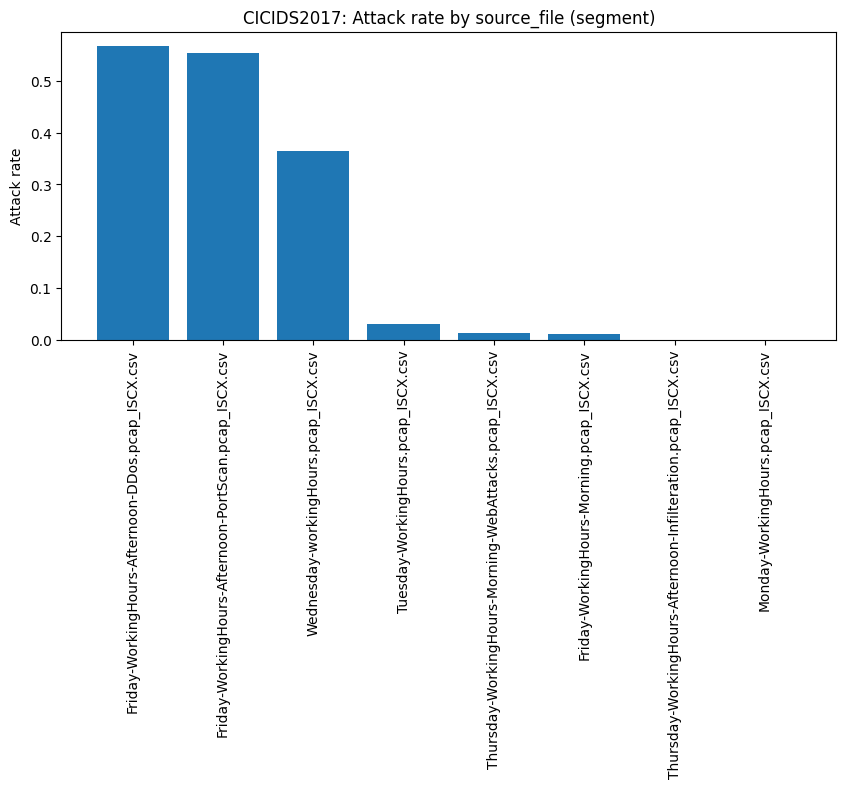

In [25]:
# --- CIC: attack rate per source_file ---
cic_seg = cic.groupby("source_file")["y"].agg(["count", "mean"]).reset_index()
cic_seg = cic_seg.rename(columns={"count":"n_samples", "mean":"attack_rate"}).sort_values("attack_rate", ascending=False)

display(cic_seg.head(15))

plt.figure(figsize=(10,4))
plt.bar(cic_seg["source_file"].astype(str), cic_seg["attack_rate"])
plt.xticks(rotation=90)
plt.title("CICIDS2017: Attack rate by source_file (segment)")
plt.ylabel("Attack rate")
plt.tight_layout()
plt.show()


**Segment-level insight (CICIDS2017):**  
Attack prevalence varies drastically across capture files (source_file).  
Some segments (e.g., Friday afternoon DDoS / PortScan) exhibit attack rates above 55%, while others (e.g., Monday working hours) contain no attacks at all.

This confirms that CICIDS2017 is composed of scenario-specific captures rather than homogeneous traffic, and highlights the necessity of leakage-aware train/test splitting by source_file.



UNSW segment by: proto


,proto,n_samples,attack_rate
0,3pc,32,1.0
1,a/n,32,1.0
2,aes-sp3-d,32,1.0
3,any,96,1.0
4,argus,33,1.0
5,aris,32,1.0
7,ax.25,32,1.0
9,bna,32,1.0
8,bbn-rcc,34,1.0
10,br-sat-mon,32,1.0


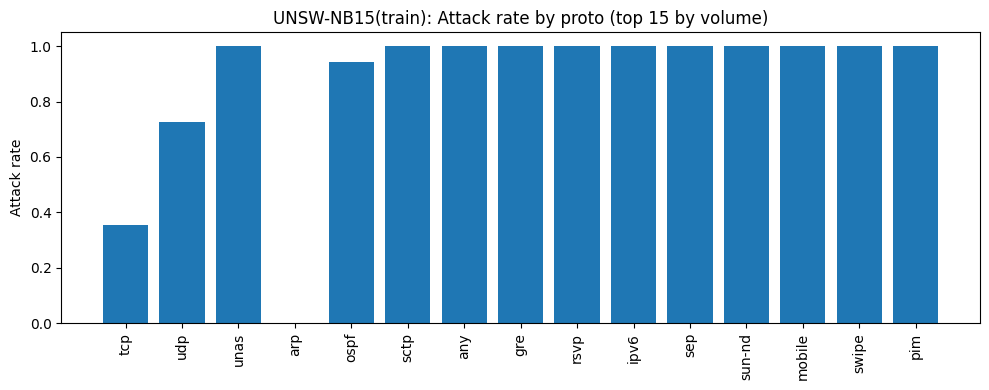


UNSW segment by: service


,service,n_samples,attack_rate
1,dhcp,26,1.000000
10,snmp,29,1.000000
12,ssl,30,1.000000
7,pop3,423,1.000000
6,irc,5,1.000000
2,dns,21367,0.856414
8,radius,9,0.777778
9,smtp,1851,0.656942
5,http,8287,0.515748
3,ftp,1552,0.511598


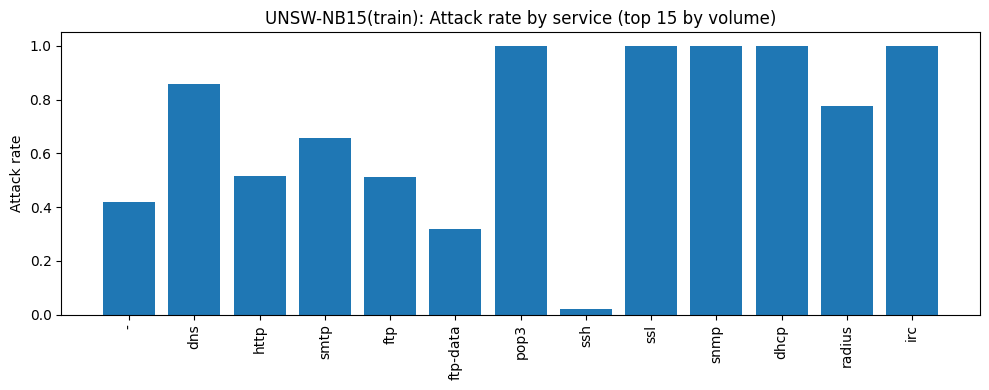


UNSW segment by: state


,state,n_samples,attack_rate
1,CLO,1,1.000000
4,INT,34163,0.868718
0,ACC,4,0.500000
3,FIN,39339,0.385546
5,REQ,1842,0.073290
2,CON,6982,0.049986
6,RST,1,0.000000


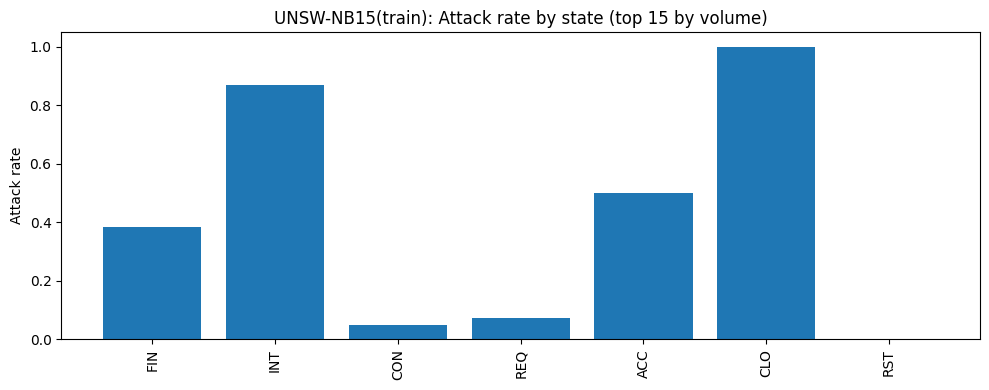

In [26]:
# --- UNSW: segment attack rate by categorical columns (if exist) ---
unsw_seg_cols = [c for c in ["proto", "service", "state"] if c in unsw_train.columns]

for col in unsw_seg_cols:
    seg = unsw_train.groupby(col)["label"].agg(["count","mean"]).reset_index()
    seg = seg.rename(columns={"count":"n_samples","mean":"attack_rate"}).sort_values("attack_rate", ascending=False)

    print(f"\nUNSW segment by: {col}")
    display(seg.head(15))

    # plot top 15 by sample size (more stable)
    top = seg.sort_values("n_samples", ascending=False).head(15)
    plt.figure(figsize=(10,4))
    plt.bar(top[col].astype(str), top["attack_rate"])
    plt.xticks(rotation=90)
    plt.title(f"UNSW-NB15(train): Attack rate by {col} (top 15 by volume)")
    plt.ylabel("Attack rate")
    plt.tight_layout()
    plt.show()


**Segment-level insight:** attack prevalence is not uniform across segments (days/sessions in CIC, and protocol/service categories in UNSW).  
This suggests dataset-specific artifacts and motivates leakage-aware evaluation and potentially segment-aware IDS strategies.


### 13B) Spectral Clustering (Graph-based Unsupervised Sanity Check)

Spectral clustering constructs a similarity graph (kNN graph) and uses the graph Laplacian eigenvectors
to embed the data, followed by clustering. We evaluate how well the unsupervised clusters align with
ground-truth labels using ARI and NMI.


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


SpectralClustering (n_neighbors=10): ARI=0.0206, NMI=0.0199


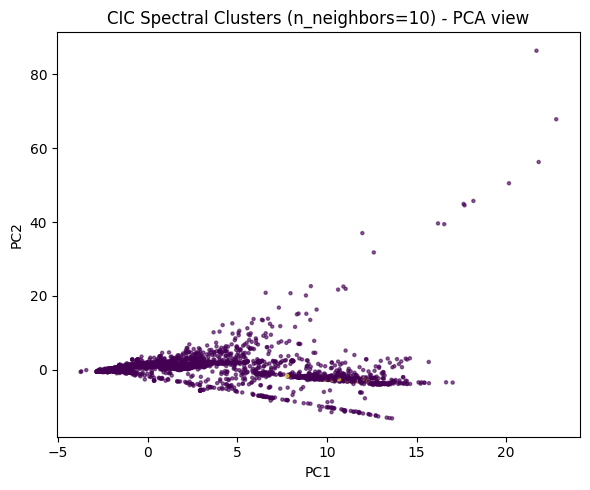

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


SpectralClustering (n_neighbors=20): ARI=0.0206, NMI=0.0199


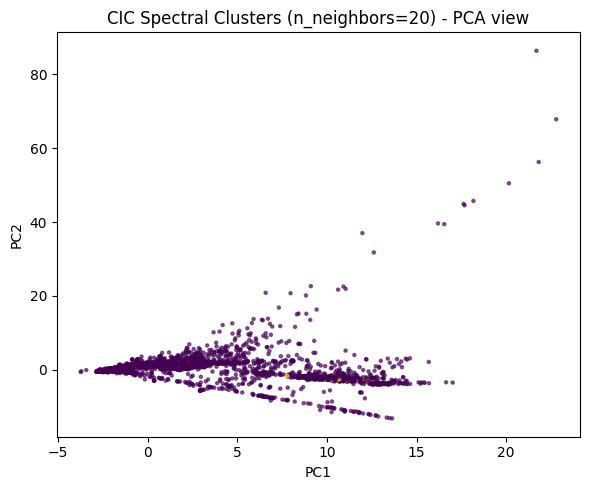

In [27]:
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Use a manageable sample from CIC train
rng = np.random.RandomState(RANDOM_STATE)
sample_n = 8000
idx = rng.choice(len(Xc_train_model), size=min(sample_n, len(Xc_train_model)), replace=False)

X_s = Xc_train_model.iloc[idx].copy()
y_s = yc_train.iloc[idx].copy()

# preprocess numeric matrix for clustering
unsup_prep = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
X_mat = unsup_prep.fit_transform(X_s)

# Try a couple of kNN settings for spectral affinity
for n_neighbors in [10, 20]:
    sc = SpectralClustering(
        n_clusters=2,
        affinity="nearest_neighbors",
        n_neighbors=n_neighbors,
        random_state=RANDOM_STATE
    )
    clusters = sc.fit_predict(X_mat)

    ari = adjusted_rand_score(y_s, clusters)
    nmi = normalized_mutual_info_score(y_s, clusters)

    print(f"SpectralClustering (n_neighbors={n_neighbors}): ARI={ari:.4f}, NMI={nmi:.4f}")

    # PCA visualization
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_2d = pca.fit_transform(X_mat)

    plt.figure(figsize=(6,5))
    plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters, s=5, alpha=0.6)
    plt.title(f"CIC Spectral Clusters (n_neighbors={n_neighbors}) - PCA view")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()


**Unsupervised conclusion:** spectral clustering may capture some structure in the traffic data,
but alignment with attack/benign labels is typically partial. This supports using supervised IDS models
when labeled data is available.


**Spectral clustering results:**  
Spectral clustering yields very low alignment with ground-truth labels (ARI ≈ 0.02, NMI ≈ 0.02), regardless of neighborhood size.

This indicates that benign and malicious traffic do not form clearly separable clusters in an unsupervised setting.  
The result supports the use of supervised or semi-supervised approaches for intrusion detection when labels are available.


### 13C) Graph-based Semi-Supervised Learning: Label Spreading

In real IDS settings, labeling is expensive. We test a graph-based semi-supervised method that propagates
labels over a similarity graph. We hide a portion of training labels and evaluate how well the method
recovers them.


In [28]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.model_selection import train_test_split

# Semi-supervised experiment on CIC train (subset for runtime)
rng = np.random.RandomState(RANDOM_STATE)
semi_n = 12000
idx2 = rng.choice(len(Xc_train_model), size=min(semi_n, len(Xc_train_model)), replace=False)

X_semi = Xc_train_model.iloc[idx2].copy()
y_semi_true = yc_train.iloc[idx2].copy().values

# preprocess numeric matrix
X_semi_mat = unsup_prep.fit_transform(X_semi)

# hide a portion of labels (simulate limited supervision)
y_semi = y_semi_true.copy()
hide_frac = 0.7  # 70% unlabeled
mask = rng.rand(len(y_semi)) < hide_frac
y_semi[mask] = -1  # unlabeled in sklearn semi-supervised

print("Labeled fraction:", (y_semi != -1).mean().round(3))

# Fit Label Spreading (graph-based)
ls = LabelSpreading(kernel="knn", n_neighbors=15, alpha=0.2, max_iter=50)
ls.fit(X_semi_mat, y_semi)

# Evaluate on the originally unlabeled points only
pred = ls.transduction_
unlabeled_idx = np.where(mask)[0]

# compute metrics on recovered labels
proba_attack = ls.label_distributions_[unlabeled_idx, 1]
metrics_ls = eval_binary(y_semi_true[unlabeled_idx], proba_attack, threshold=0.5)

print("LabelSpreading (on unlabeled subset) metrics:")
for k,v in metrics_ls.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")


Labeled fraction: 0.29
LabelSpreading (on unlabeled subset) metrics:
  PR-AUC: 0.9730
  ROC-AUC: 0.9901
  Precision(attack): 0.9551
  Recall(attack): 0.9417
  F1(attack): 0.9484
  TN: 7037
  FP: 63
  FN: 83
  TP: 1341


**Graph-method conclusion:** label propagation can be useful when only a subset of data is labeled,
but performance depends on the quality of the similarity graph (feature scaling, noise, and local structure).
This complements the supervised IDS pipeline rather than replacing it.


**Graph-based semi-supervised learning:**  
Label Spreading achieves strong performance even when only ~29% of samples are labeled (PR-AUC ≈ 0.97, Recall ≈ 0.94).

This suggests that local similarity structure can be leveraged for intrusion detection under limited supervision.  
However, performance depends heavily on feature representation and graph quality, and does not replace fully supervised IDS models in complex, noisy environments.


## 14) Limitations & Future Work

### Limitations
- Dataset bias: CIC and UNSW reflect specific traffic captures and attack catalogs.
- Concept drift: real-world network behavior changes over time.
- Feature mismatch: different feature extraction pipelines → not directly comparable column-wise.
- Potential label noise and duplicated patterns.


### Future Work
- Temporal split by day (train on early days, test on later days) for stronger realism.
- Cost-sensitive learning / tuning thresholds for SOC needs.
- Online / streaming detection, anomaly detection, or semi-supervised methods.
- Domain adaptation between datasets.
- Construct explicit flow graphs / host graphs (IP-level) if raw logs are available; explore community detection.
